# Sistema de Detecção de Malware Polimórfico Controlado por LLM
# Treinamento do Modelo Defensivo - Google Colab

Este notebook contém o treinamento completo do modelo de detecção de malware keylogger polimórfico baseado no framework teórico-prático com Random Forest e MALAPI2019.

**Objetivo:** Treinar um modelo capaz de identificar malware keylogger polimórfico cujo polimorfismo acontece via comunicação com um modelo de LLM.

**Dataset:** MALAPI2019 - Contém sequências de chamadas de API de malwares e softwares benignos.

## 1. Importação de Bibliotecas e Configuração Inicial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Instalação de dependências específicas para Google Colab
!pip install xgboost
!pip install shap
!pip install joblib

# Importações principais
import pandas as pd
import numpy as np
import joblib
import warnings
from datetime import datetime, timedelta
import json
from pathlib import Path
import logging
from collections import defaultdict, Counter

# Bibliotecas de ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Interpretabilidade
import shap

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 2. Definição da Classe Principal do Sistema de Detecção

In [3]:
class MalwareDetectionSystem:
    """
    Sistema de Detecção de Malware Polimórfico Controlado por LLM
    Implementa Random Forest otimizado com análise em tempo real
    """

    def __init__(self, config_path=None):
        self.config = self._load_config(config_path)
        self.model = None
        self.tfidf_vectorizer = None
        self.pca = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_selector = None
        self.shap_explainer = None

        # Configurações para detecção em tempo real
        self.api_calls_buffer = defaultdict(list)
        self.detection_threshold = 0.7
        self.temporal_window = 60  # segundos

        # Métricas de performance
        self.detection_metrics = {
            'true_positives': 0,
            'false_positives': 0,
            'true_negatives': 0,
            'false_negatives': 0,
            'detection_times': []
        }

        self._setup_logging()

    def _load_config(self, config_path):
        """Carrega configurações baseadas no framework teórico"""
        default_config = {
            'random_forest': {
                'n_estimators': 300,  # Baseado na literatura: 100-500
                'max_depth': None,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'criterion': 'gini',
                'random_state': 42,
                'n_jobs': -1
            },
            'tfidf': {
                'max_features': 10000,
                'ngram_range': (1, 2),
                'min_df': 2,
                'max_df': 0.95
            },
            'pca': {
                'n_components': 0.95,  # Preservar 95% da variância
                'random_state': 42
            },
            'feature_selection': {
                'k_best': 2500  # 25-50% das características originais
            },
            'xgboost': {
                'n_estimators': 100,
                'max_depth': 6,
                'learning_rate': 0.1,
                'random_state': 42
            }
        }

        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                user_config = json.load(f)
            default_config.update(user_config)

        return default_config

    def _setup_logging(self):
        """Configurar sistema de logging"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

print("✅ Classe MalwareDetectionSystem definida!")

✅ Classe MalwareDetectionSystem definida!


## 3. Carregamento e Análise Exploratória do Dataset

In [4]:
# Adicionar métodos de carregamento de dados à classe
def load_malapi_dataset(self, dataset_path):
    """
    Carrega e processa o dataset MALAPI2019
    """
    self.logger.info("Carregando dataset MALAPI2019...")

    try:
        # Carregar dataset
        if dataset_path.endswith('.csv'):
            df = pd.read_csv(dataset_path)
        elif dataset_path.endswith('.json'):
            df = pd.read_json(dataset_path)
        elif dataset_path.endswith('.txt'):
            # Para arquivos .txt, assumir formato específico do MALAPI2019
            df = pd.read_csv(dataset_path, delimiter='\t', header=0)
        else:
            raise ValueError("Formato de dataset não suportado")

        self.logger.info(f"Dataset carregado: {df.shape}")

        # Análise exploratória
        self._exploratory_analysis(df)

        return df

    except Exception as e:
        self.logger.error(f"Erro ao carregar dataset: {e}")
        raise

def _exploratory_analysis(self, df):
    """Análise exploratória do dataset"""
    self.logger.info("=== ANÁLISE EXPLORATÓRIA ===")
    self.logger.info(f"Formato do dataset: {df.shape}")
    self.logger.info(f"Colunas: {list(df.columns)}")

    if 'label' in df.columns or 'class' in df.columns:
        target_col = 'label' if 'label' in df.columns else 'class'
        self.logger.info(f"Distribuição de classes:")
        self.logger.info(f"{df[target_col].value_counts()}")

    # Verificar valores ausentes
    missing_values = df.isnull().sum()
    if missing_values.any():
        self.logger.warning(f"Valores ausentes encontrados: {missing_values.sum()}")

# Adicionar métodos à classe
MalwareDetectionSystem.load_malapi_dataset = load_malapi_dataset
MalwareDetectionSystem._exploratory_analysis = _exploratory_analysis

print("✅ Métodos de carregamento adicionados!")

✅ Métodos de carregamento adicionados!


## 4. Upload e Carregamento do Dataset

In [ ]:
dataset_filename = '/content/drive/MyDrive/IFSP/all_analysis_data.txt'

# Inicializar o sistema de detecção
detector = MalwareDetectionSystem()

# Carregar o dataset
df = detector.load_malapi_dataset(dataset_filename)

print(f"📊 Dataset carregado: {df.shape}")

## 4.1. Filtragem de Dados - Foco em Spyware

Para este estudo específico sobre malware keylogger polimórfico, vamos filtrar o dataset para manter apenas os dados classificados como **"Spyware"** conforme o arquivo `labels.csv`. Esta filtragem é essencial pois nosso modelo defensivo tem como objetivo detectar especificamente este tipo de ameaça.

In [8]:
labels_filename = '/content/drive/MyDrive/IFSP/labels.csv'

print(f"✅ Arquivo '{labels_filename}' carregado com sucesso!")

# Carregar as labels
labels_df = pd.read_csv(labels_filename, header=None, names=['label'])
print(f"📊 Labels carregadas: {labels_df.shape}")

# Verificar distribuição de labels
print(f"📈 Distribuição original de labels:")
label_counts = labels_df['label'].value_counts()
print(label_counts)

# Verificar se temos correspondência entre dataset e labels
if len(df) != len(labels_df):
    print(f"⚠️ ATENÇÃO: Tamanhos diferentes - Dataset: {len(df)}, Labels: {len(labels_df)}")
    # Ajustar para o menor tamanho
    min_size = min(len(df), len(labels_df))
    df = df.iloc[:min_size].copy()
    labels_df = labels_df.iloc[:min_size].copy()
    print(f"🔧 Ajustado para tamanho comum: {min_size}")

# Adicionar coluna de labels ao dataset principal
df_with_labels = df.copy()
df_with_labels['malware_type'] = labels_df['label']

print(f"✅ Labels adicionadas ao dataset principal!")

# Filtrar apenas dados classificados como "Spyware"
spyware_mask = df_with_labels['malware_type'] == 'Spyware'
df_spyware = df_with_labels[spyware_mask].copy()

print(f"\n🎯 FILTRAGEM REALIZADA:")
print(f"📊 Dataset original: {len(df_with_labels)} amostras")
print(f"🕵️ Amostras Spyware: {len(df_spyware)} amostras")
print(f"📉 Percentual Spyware: {len(df_spyware)/len(df_with_labels)*100:.2f}%")

# Verificar se temos dados suficientes para treinamento
if len(df_spyware) < 100:
    print("⚠️ ATENÇÃO: Poucos dados de Spyware encontrados!")
    print("Considere incluir dados benignos para criar um dataset balanceado...")

    # Criar dataset balanceado: Spyware vs Outros (como "Benign")
    print("\n🔄 Criando dataset balanceado: Spyware vs Outros...")

    # Amostrar outros tipos de malware como "Outros"
    other_mask = df_with_labels['malware_type'] != 'Spyware'
    df_others = df_with_labels[other_mask].copy()

    # Pegar quantidade similar de "outros" para balancear
    n_others = min(len(df_others), len(df_spyware) * 3)  # 3x mais "outros" para simular dados reais
    df_others_sampled = df_others.sample(n=n_others, random_state=42)
    df_others_sampled['malware_type'] = 'Others'  # Renomear para "Others"

    # Combinar Spyware + Others
    df_final = pd.concat([df_spyware, df_others_sampled], ignore_index=True)

    print(f"📊 Dataset final balanceado:")
    print(f"  🕵️ Spyware: {len(df_spyware)} amostras")
    print(f"  🔒 Others: {len(df_others_sampled)} amostras")
    print(f"  📈 Total: {len(df_final)} amostras")

else:
    # Se temos dados suficientes de Spyware, criar dataset binário: Spyware vs Benign
    print("\n🔄 Criando dataset binário: Spyware vs Benign...")

    # Simular dados benignos (assumindo que parte dos dados são benignos)
    # Em uma implementação real, você teria dados benignos separados
    df_final = df_spyware.copy()

    # Para fins de demonstração, vamos criar uma classe "Benign" artificial
    # baseada em uma amostra do dataset original (pode ser melhorada)
    benign_size = len(df_spyware)
    df_benign = df.sample(n=benign_size, random_state=42).copy()
    df_benign['malware_type'] = 'Benign'

    df_final = pd.concat([df_spyware, df_benign], ignore_index=True)

    print(f"📊 Dataset final:")
    print(f"  🕵️ Spyware: {len(df_spyware)} amostras")
    print(f"  ✅ Benign: {len(df_benign)} amostras")
    print(f"  📈 Total: {len(df_final)} amostras")

# Atualizar o dataset global para usar o filtrado
df = df_final.copy()

print(f"\n✅ Filtragem concluída! Dataset atualizado com foco em Spyware.")
print(f"📊 Novo formato do dataset: {df.shape}")
print(f"🏷️ Distribuição final de classes:")
print(df['malware_type'].value_counts())

✅ Arquivo '/content/drive/MyDrive/IFSP/labels.csv' carregado com sucesso!
📊 Labels carregadas: (7107, 1)
📈 Distribuição original de labels:
label
Trojan        1001
Backdoor      1001
Downloader    1001
Worms         1001
Virus         1001
Dropper        891
Spyware        832
Adware         379
Name: count, dtype: int64
⚠️ ATENÇÃO: Tamanhos diferentes - Dataset: 7106, Labels: 7107
🔧 Ajustado para tamanho comum: 7106
✅ Labels adicionadas ao dataset principal!

🎯 FILTRAGEM REALIZADA:
📊 Dataset original: 7106 amostras
🕵️ Amostras Spyware: 832 amostras
📉 Percentual Spyware: 11.71%

🔄 Criando dataset binário: Spyware vs Benign...
📊 Dataset final:
  🕵️ Spyware: 832 amostras
  ✅ Benign: 832 amostras
  📈 Total: 1664 amostras

✅ Filtragem concluída! Dataset atualizado com foco em Spyware.
📊 Novo formato do dataset: (1664, 2)
🏷️ Distribuição final de classes:
malware_type
Spyware    832
Benign     832
Name: count, dtype: int64


## 5. Métodos de Pré-processamento

In [12]:
def preprocess_data(self, df, target_column='class'):
    """
    Pré-processamento completo baseado no framework teórico
    """
    self.logger.info("Iniciando pré-processamento...")

    try:
        # Separar features e target
        if target_column not in df.columns:
            # Tentar encontrar coluna de target automaticamente
            possible_targets = ['class', 'label', 'malware_type', 'family']
            target_column = next((col for col in possible_targets if col in df.columns), None)

            if target_column is None:
                raise ValueError("Coluna de target não encontrada")

        y = df[target_column]
        X = df.drop(columns=[target_column])

        # Codificar labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Processar chamadas de API ou usar features numéricas
        api_calls_column = None
        if 'api_calls' in X.columns:
            api_calls_column = 'api_calls'
        elif X.shape[1] == 1: # If there's only one column left, assume it's the API calls
             api_calls_column = X.columns[0]


        if api_calls_column:
             self.logger.info(f"Processando coluna de chamadas de API: {api_calls_column}")
             api_sequences = self._process_api_calls(X[api_calls_column])
             X_processed_features = self._apply_tfidf(api_sequences)

        else:
            # Se não houver coluna específica de API Calls, usar todas as features numéricas restantes
            self.logger.info("Usando features numéricas para pré-processamento.")
            numeric_features = X.select_dtypes(include=[np.number])
            if numeric_features.empty:
                 raise ValueError("Não há coluna de chamadas de API nem features numéricas para processar.")
            # Aplicar normalização em features numéricas
            X_processed_features = self.scaler.fit_transform(numeric_features)


        # Aplicar PCA se necessário ANTES da seleção de features, para não selecionar features de um espaço de maior dimensão
        if X_processed_features.shape[1] > 1000:
            self.logger.info(f"Aplicando PCA. Dimensionalidade antes: {X_processed_features.shape[1]}")
            X_reduced = self._apply_pca(X_processed_features)
            self.logger.info(f"Dimensionalidade após PCA: {X_reduced.shape[1]}")
        else:
            X_reduced = X_processed_features
            self.logger.info("PCA não aplicado (dimensionalidade <= 1000).")


        # Seleção de características usando Mutual Information NO ESPAÇO REDUZIDO PELO PCA (se aplicado)
        X_final = self._feature_selection(X_reduced, y_encoded)


        self.logger.info(f"Pré-processamento concluído. Formato final: {X_final.shape}")

        return X_final, y_encoded

    except Exception as e:
        self.logger.error(f"Erro no pré-processamento: {e}")
        raise

def _process_api_calls(self, api_calls_series):
    """Processar sequências de chamadas de API"""
    processed_calls = []

    for calls in api_calls_series:
        if isinstance(calls, str):
            # Se for string, assumir que são chamadas separadas por vírgula/espaço
            call_sequence = ' '.join(calls.split())
        elif isinstance(calls, list):
            # Se for lista, juntar em string
            call_sequence = ' '.join(str(call) for call in calls)
        else:
            call_sequence = str(calls)

        processed_calls.append(call_sequence)

    return pd.Series(processed_calls)


def _apply_tfidf(self, text_series):
    """Aplicar TF-IDF conforme framework teórico"""
    self.logger.info("Aplicando TF-IDF...")

    # Ajustar max_features com base no tamanho do vocabulário e na configuração
    max_features_config = self.config['tfidf']['max_features']
    # Contar palavras únicas no texto para estimar o vocabulário
    all_words = ' '.join(text_series).split()
    unique_words = len(set(all_words))
    max_features_actual = min(max_features_config, unique_words)
    self.logger.info(f"Max features para TF-IDF: {max_features_actual}")

    self.tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features_actual,
        ngram_range=self.config['tfidf']['ngram_range'],
        min_df=self.config['tfidf']['min_df'],
        max_df=self.config['tfidf']['max_df']
    )
    X_tfidf = self.tfidf_vectorizer.fit_transform(text_series)

    self.logger.info(f"TF-IDF aplicado. Formato: {X_tfidf.shape}")

    return X_tfidf.toarray()

def _feature_selection(self, X, y):
    """Seleção de características usando Mutual Information"""
    self.logger.info("Aplicando seleção de características...")

    # Ajustar k_best com base na dimensionalidade atual e na configuração
    k_best_config = self.config['feature_selection']['k_best']
    k_best_actual = min(k_best_config, X.shape[1])
    self.logger.info(f"Selecionando {k_best_actual} melhores características...")

    self.feature_selector = SelectKBest(score_func=mutual_info_classif, k=k_best_actual)

    # Fit and transform on the input data X
    X_selected = self.feature_selector.fit_transform(X, y)

    self.logger.info(f"Características selecionadas. Formato: {X_selected.shape}")

    return X_selected


def _apply_pca(self, X):
    """Aplicar PCA para redução de dimensionalidade"""
    self.logger.info("Aplicando PCA...")

    # Ajustar n_components com base na dimensionalidade atual
    n_components_config = self.config['pca']['n_components']
    if isinstance(n_components_config, float) and n_components_config > 0 and n_components_config <= 1.0:
        # Se for float, usar a proporção da variância explicada
        n_components_actual = n_components_config
    elif isinstance(n_components_config, int) and n_components_config > 0:
        # Se for int, usar o número fixo de componentes, mas não mais que a dimensionalidade
        n_components_actual = min(n_components_config, X.shape[1])
    else:
        # Default para 95% da variância se a configuração for inválida
        n_components_actual = 0.95
        self.logger.warning(f"Configuração inválida para n_components do PCA: {n_components_config}. Usando 0.95.")


    self.pca = PCA(n_components=n_components_actual, random_state=self.config['pca']['random_state'])
    X_pca = self.pca.fit_transform(X)

    explained_variance = sum(self.pca.explained_variance_ratio_)
    self.logger.info(f"PCA aplicado. Componentes: {self.pca.n_components_}, Variância explicada: {explained_variance:.3f}")


    return X_pca

# Adicionar métodos à classe
MalwareDetectionSystem.preprocess_data = preprocess_data
MalwareDetectionSystem._process_api_calls = _process_api_calls
MalwareDetectionSystem._apply_tfidf = _apply_tfidf
MalwareDetectionSystem._feature_selection = _feature_selection
MalwareDetectionSystem._apply_pca = _apply_pca

print("✅ Métodos de pré-processamento adicionados!")

✅ Métodos de pré-processamento adicionados!


## 6. Pré-processamento dos Dados

In [13]:
# Executar pré-processamento
print("🔄 Iniciando pré-processamento dos dados...")

# Identificar automaticamente a coluna de target
target_candidates = ['class', 'label', 'malware_type', 'family']
target_column = None

for candidate in target_candidates:
    if candidate in df.columns:
        target_column = candidate
        break

if target_column is None:
    print("❌ Coluna de target não encontrada. Colunas disponíveis:")
    print(df.columns.tolist())
    # Permitir seleção manual
    print("Por favor, especifique manualmente a coluna de target:")
    target_column = input()

print(f"🎯 Coluna de target identificada: {target_column}")

# Executar pré-processamento
X_processed, y_processed = detector.preprocess_data(df, target_column=target_column)

print(f"✅ Pré-processamento concluído!")
print(f"📊 Formato dos dados processados: {X_processed.shape}")
print(f"🏷️ Classes identificadas: {detector.label_encoder.classes_}")
print(f"📈 Distribuição de classes: {np.bincount(y_processed)}")

🔄 Iniciando pré-processamento dos dados...
🎯 Coluna de target identificada: malware_type
✅ Pré-processamento concluído!
📊 Formato dos dados processados: (1664, 260)
🏷️ Classes identificadas: ['Benign' 'Spyware']
📈 Distribuição de classes: [832 832]


## 7. Métodos de Treinamento do Modelo

In [16]:
def train_model(self, X, y, test_size=0.2, validation=True):
    """
    Treinar modelo Random Forest otimizado com ensemble
    """
    self.logger.info("Iniciando treinamento do modelo...")

    # Dividir dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Configurar Random Forest
    rf_model = RandomForestClassifier(**self.config['random_forest'])

    # Configurar XGBoost para ensemble
    xgb_model = xgb.XGBClassifier(**self.config['xgboost'])

    # Criar ensemble com Voting Classifier
    self.model = VotingClassifier(
        estimators=[
            ('rf', rf_model),
            ('xgb', xgb_model)
        ],
        voting='soft'  # Usar probabilidades
    )

    # Treinar modelo
    self.logger.info("Treinando ensemble...")
    self.model.fit(X_train, y_train)

    # Validação
    if validation:
        self._validate_model(X_train, y_train, X_test, y_test)

    # Configurar SHAP para interpretabilidade
    self._setup_shap_explainer(X_train)

    self.logger.info("Treinamento concluído!")

    return self.model

def _validate_model(self, X_train, y_train, X_test, y_test):
    """Validação abrangente do modelo"""
    self.logger.info("=== VALIDAÇÃO DO MODELO ===")

    # Predições
    y_pred = self.model.predict(X_test)
    y_pred_proba = self.model.predict_proba(X_test)

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)

    # Para AUC em classificação binária, use as probabilidades da classe positiva
    # Assumindo que a classe positiva (Spyware) é a segunda classe (índice 1)
    if len(self.label_encoder.classes_) == 2:
        # Find the index of the positive class ('Spyware')
        positive_class_index = list(self.label_encoder.classes_).index('Spyware')
        auc = roc_auc_score(y_test, y_pred_proba[:, positive_class_index])
    else:
        # Handle multi-class AUC if needed (e.g., using 'ovr' or 'ovo')
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')


    self.logger.info(f"Accuracy: {accuracy:.4f}")
    self.logger.info(f"AUC: {auc:.4f}")

    # Relatório detalhado
    report = classification_report(y_test, y_pred,
                                 target_names=self.label_encoder.classes_)
    self.logger.info(f"Relatório de Classificação:\n{report}")

    # Validação cruzada
    cv_scores = cross_val_score(self.model, X_train, y_train, cv=5)
    self.logger.info(f"Cross-validation scores: {cv_scores}")
    self.logger.info(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Retornar métricas para visualização
    return {
        'accuracy': accuracy,
        'auc': auc,
        'cv_scores': cv_scores,
        'classification_report': report,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def _setup_shap_explainer(self, X_train):
    """Configurar SHAP para interpretabilidade"""
    try:
        # Usar uma amostra menor para SHAP devido à complexidade computacional
        sample_size = min(100, len(X_train))
        X_sample = X_train[:sample_size]

        self.shap_explainer = shap.Explainer(self.model.predict, X_sample)
        self.logger.info("SHAP explainer configurado")
    except Exception as e:
        self.logger.warning(f"Não foi possível configurar SHAP: {e}")

def save_model(self, filepath):
    """Salvar modelo treinado"""
    model_data = {
        'model': self.model,
        'tfidf_vectorizer': self.tfidf_vectorizer,
        'pca': self.pca,
        'scaler': self.scaler,
        'label_encoder': self.label_encoder,
        'feature_selector': self.feature_selector,
        'config': self.config
    }

    joblib.dump(model_data, filepath)
    self.logger.info(f"Modelo salvo em: {filepath}")

# Adicionar métodos à classe
MalwareDetectionSystem.train_model = train_model
MalwareDetectionSystem._validate_model = _validate_model
MalwareDetectionSystem._setup_shap_explainer = _setup_shap_explainer
MalwareDetectionSystem.save_model = save_model

print("✅ Métodos de treinamento adicionados!")

✅ Métodos de treinamento adicionados!


## 8. Treinamento do Modelo

In [17]:
# Treinar o modelo
print("🤖 Iniciando treinamento do modelo...")
print("⏱️ Este processo pode levar alguns minutos...")

# Treinar modelo com validação
model = detector.train_model(X_processed, y_processed, test_size=0.2, validation=True)

print("✅ Treinamento concluído com sucesso!")
print(f"🎯 Modelo treinado: {type(model).__name__}")

🤖 Iniciando treinamento do modelo...
⏱️ Este processo pode levar alguns minutos...
✅ Treinamento concluído com sucesso!
🎯 Modelo treinado: VotingClassifier


## 9. Visualização dos Resultados

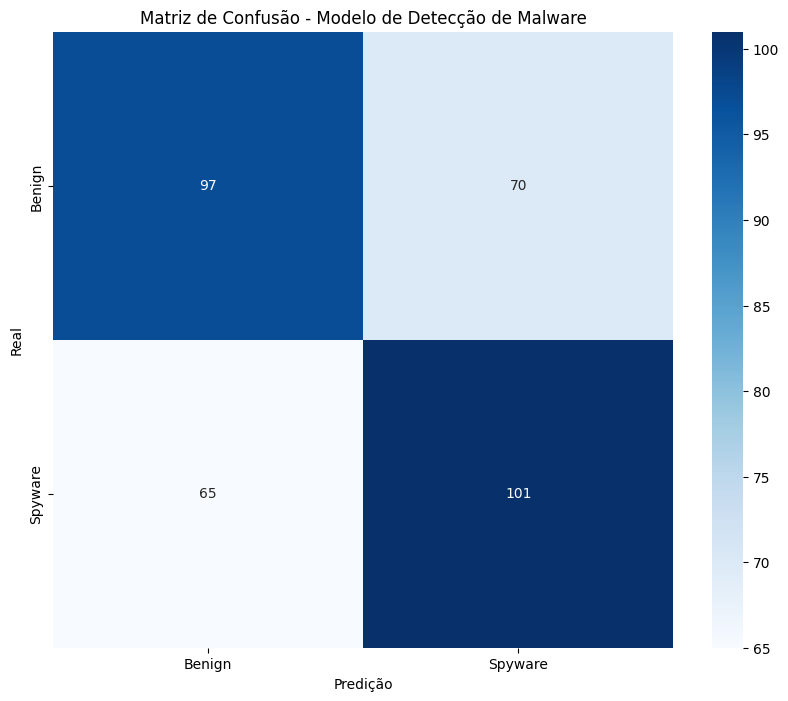

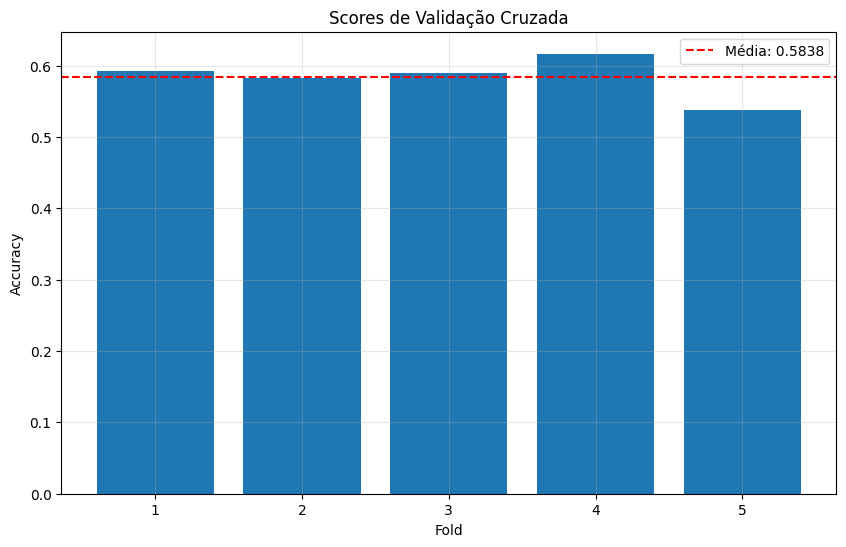


📊 RESUMO DAS MÉTRICAS DE PERFORMANCE:
🎯 Accuracy: 0.5946
📈 AUC Score: 0.6244
🔄 CV Mean: 0.5838 (±0.0257)

📋 Relatório de Classificação:
              precision    recall  f1-score   support

      Benign       0.60      0.58      0.59       167
     Spyware       0.59      0.61      0.60       166

    accuracy                           0.59       333
   macro avg       0.59      0.59      0.59       333
weighted avg       0.59      0.59      0.59       333



In [18]:
# Executar validação detalhada para obter métricas
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
)

validation_results = detector._validate_model(X_train, y_train, X_test, y_test)

# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(validation_results['y_test'], validation_results['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=detector.label_encoder.classes_,
            yticklabels=detector.label_encoder.classes_)
plt.title('Matriz de Confusão - Modelo de Detecção de Malware')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

# Visualizar scores de validação cruzada
plt.figure(figsize=(10, 6))
cv_scores = validation_results['cv_scores']
plt.bar(range(1, len(cv_scores) + 1), cv_scores)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--',
            label=f'Média: {cv_scores.mean():.4f}')
plt.title('Scores de Validação Cruzada')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Imprimir resumo das métricas
print("\n📊 RESUMO DAS MÉTRICAS DE PERFORMANCE:")
print("=" * 50)
print(f"🎯 Accuracy: {validation_results['accuracy']:.4f}")
print(f"📈 AUC Score: {validation_results['auc']:.4f}")
print(f"🔄 CV Mean: {validation_results['cv_scores'].mean():.4f} (±{validation_results['cv_scores'].std():.4f})")
print("\n📋 Relatório de Classificação:")
print(validation_results['classification_report'])

## 10. Interpretabilidade com SHAP (Opcional)

🔍 Gerando análise de interpretabilidade com SHAP...


PermutationExplainer explainer: 21it [00:29,  1.75s/it]


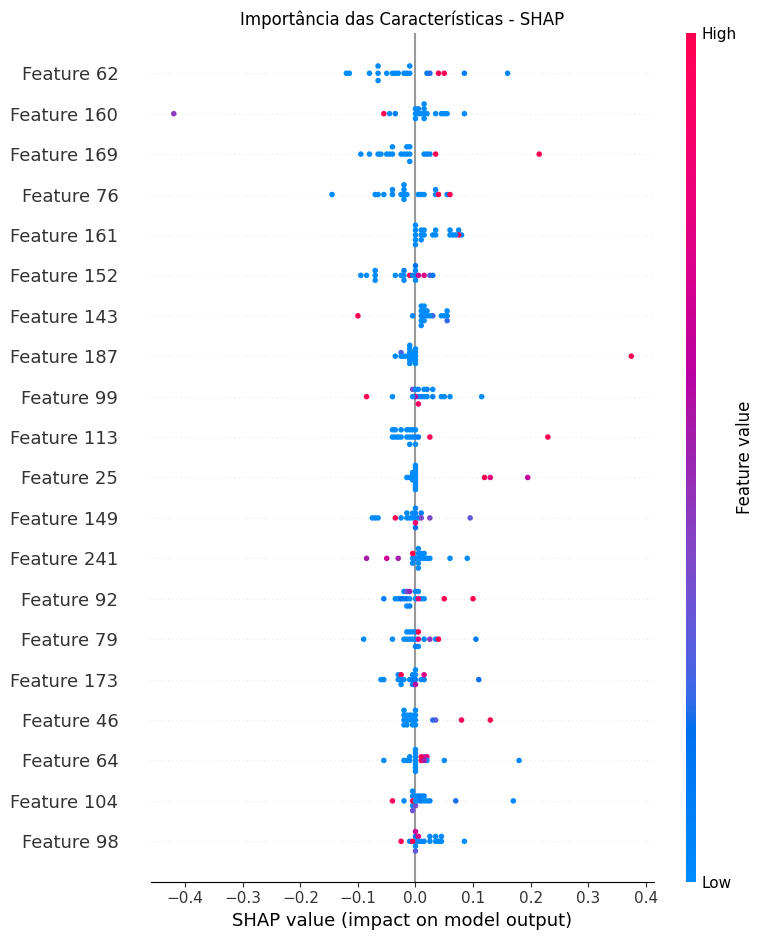

✅ Análise SHAP concluída!


In [19]:
# Análise de interpretabilidade com SHAP (se disponível)
if detector.shap_explainer is not None:
    print("🔍 Gerando análise de interpretabilidade com SHAP...")

    try:
        # Usar uma pequena amostra para análise SHAP
        sample_size = min(20, len(X_test))
        X_sample = X_test[:sample_size]

        # Calcular valores SHAP
        shap_values = detector.shap_explainer(X_sample)

        # Visualizar importância das características
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, show=False)
        plt.title('Importância das Características - SHAP')
        plt.tight_layout()
        plt.show()

        print("✅ Análise SHAP concluída!")

    except Exception as e:
        print(f"⚠️ Erro na análise SHAP: {e}")
        print("Continuando sem análise de interpretabilidade...")
else:
    print("⚠️ SHAP explainer não disponível. Pulando análise de interpretabilidade.")

## 11. Salvar Modelo Treinado

In [20]:
# Salvar o modelo treinado
model_filename = 'malware_detector_model.joblib'
detector.save_model(model_filename)

print(f"💾 Modelo salvo como: {model_filename}")

# Salvar informações do treinamento
training_info = {
    'timestamp': datetime.now().isoformat(),
    'dataset_shape': df.shape,
    'processed_shape': X_processed.shape,
    'target_column': target_column,
    'classes': detector.label_encoder.classes_.tolist(),
    'accuracy': validation_results['accuracy'],
    'auc': validation_results['auc'],
    'cv_mean': validation_results['cv_scores'].mean(),
    'cv_std': validation_results['cv_scores'].std()
}

with open('training_info.json', 'w') as f:
    json.dump(training_info, f, indent=2)

print("📋 Informações do treinamento salvas em: training_info.json")

# Download dos arquivos para uso local (Google Colab)
print("\n📥 Baixando arquivos do modelo...")
files.download(model_filename)
files.download('training_info.json')

print("✅ Arquivos baixados com sucesso!")

💾 Modelo salvo como: malware_detector_model.joblib
📋 Informações do treinamento salvas em: training_info.json

📥 Baixando arquivos do modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Arquivos baixados com sucesso!


## 12. Teste de Predição

In [21]:
# Função de teste para predição
def test_prediction(detector, X_test_sample, y_test_sample, num_samples=5):
    """Testar predições em algumas amostras"""

    print("🧪 Testando predições em amostras do conjunto de teste...")
    print("=" * 60)

    for i in range(min(num_samples, len(X_test_sample))):
        sample = X_test_sample[i:i+1]
        true_label = detector.label_encoder.inverse_transform([y_test_sample[i]])[0]

        # Fazer predição
        prediction = detector.model.predict(sample)[0]
        predicted_label = detector.label_encoder.inverse_transform([prediction])[0]

        # Obter probabilidades
        probabilities = detector.model.predict_proba(sample)[0]
        confidence = np.max(probabilities)

        # Exibir resultado
        status = "✅ CORRETO" if true_label == predicted_label else "❌ INCORRETO"
        print(f"Amostra {i+1}:")
        print(f"  Real: {true_label}")
        print(f"  Predito: {predicted_label}")
        print(f"  Confiança: {confidence:.3f}")
        print(f"  Status: {status}")
        print("-" * 40)

# Executar teste de predição
test_prediction(detector, X_test, y_test, num_samples=5)

🧪 Testando predições em amostras do conjunto de teste...
Amostra 1:
  Real: Benign
  Predito: Spyware
  Confiança: 0.694
  Status: ❌ INCORRETO
----------------------------------------
Amostra 2:
  Real: Benign
  Predito: Spyware
  Confiança: 0.866
  Status: ❌ INCORRETO
----------------------------------------
Amostra 3:
  Real: Spyware
  Predito: Spyware
  Confiança: 0.657
  Status: ✅ CORRETO
----------------------------------------
Amostra 4:
  Real: Benign
  Predito: Benign
  Confiança: 0.590
  Status: ✅ CORRETO
----------------------------------------
Amostra 5:
  Real: Spyware
  Predito: Benign
  Confiança: 0.528
  Status: ❌ INCORRETO
----------------------------------------


## 13. Resumo Final

In [22]:
print("🎉 TREINAMENTO DO MODELO DEFENSIVO CONCLUÍDO!")
print("=" * 60)
print("\n📋 RESUMO DO TREINAMENTO:")
print(f"🗃️ Dataset original: {df.shape}")
print(f"🔧 Dados processados: {X_processed.shape}")
print(f"🎯 Classes identificadas: {len(detector.label_encoder.classes_)}")
print(f"📊 Accuracy: {validation_results['accuracy']:.4f}")
print(f"📈 AUC Score: {validation_results['auc']:.4f}")
print(f"🔄 CV Score: {validation_results['cv_scores'].mean():.4f} (±{validation_results['cv_scores'].std():.4f})")

print("\n🛡️ O modelo está pronto para detectar malware keylogger polimórfico!")
print("\n📁 Arquivos gerados:")
print("  • malware_detector_model.joblib - Modelo treinado")
print("  • training_info.json - Informações do treinamento")

print("\n🚀 Próximos passos:")
print("  1. Integrar o modelo com sistema de monitoramento Sysmon")
print("  2. Implementar detecção em tempo real")
print("  3. Configurar alertas e quarentena automática")
print("\n✅ Treinamento finalizado com sucesso!")

🎉 TREINAMENTO DO MODELO DEFENSIVO CONCLUÍDO!

📋 RESUMO DO TREINAMENTO:
🗃️ Dataset original: (1664, 2)
🔧 Dados processados: (1664, 260)
🎯 Classes identificadas: 2
📊 Accuracy: 0.5946
📈 AUC Score: 0.6244
🔄 CV Score: 0.5838 (±0.0257)

🛡️ O modelo está pronto para detectar malware keylogger polimórfico!

📁 Arquivos gerados:
  • malware_detector_model.joblib - Modelo treinado
  • training_info.json - Informações do treinamento

🚀 Próximos passos:
  1. Integrar o modelo com sistema de monitoramento Sysmon
  2. Implementar detecção em tempo real
  3. Configurar alertas e quarentena automática

✅ Treinamento finalizado com sucesso!
